## **EVAL USING ROGUE**

In [40]:
from transformers import pipeline
import json

### Reddit Post Summarization Pipeline

This script loads a fine-tuned Transformer model to summarize Reddit posts and their comments.  
It processes an API response containing a post and its comments, then generates concise summaries for both.  

### **How It Works**
- Loads a custom summarization model (`../models/redditsummary`) using the `transformers` library.
- Defines a `summarize` function to generate summaries with dynamic length constraints.
- Extracts and processes post content and comments from the API response.
- Uses beam search (`num_beams=4`) with early stopping to improve summary quality.

### **Usage**
Pass a Reddit API response to `process_data(response, prompt)`, and it will return:
- `post_summary`: A summarized version of the original post.
- `comments_summary`: A summarized version of the top-level comments.

In [2]:
summarizer = pipeline(
            "summarization",
            model = "../models/redditsummary",
            tokenizer = "../models/redditsummary",
            device=-1
        )
        
def summarize(text, prompt):
    inputs = f"{prompt}: {text}"
    
    input_tokens = summarizer.tokenizer.encode(inputs, truncation=False)
    input_len = len(input_tokens)

    max_length = min(input_len * 2, 1024)
    min_length = max(32, input_len // 4)

    if input_len > 1024:
        inputs = summarizer.tokenizer.decode(input_tokens[:1024])

    summary = summarizer(
        inputs,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,  
    )
    
    return summary[0]['summary_text']

def process_data(response, prompt):
    post_content = response[0]['data']['children'][0]['data'].get('selftext', '')
    comments = []
    for comment in response[1]['data']['children']:
        if 'body' in comment['data']:
            comments.append(comment['data']['body'])
    comments_all = ' '.join(comments)

    post_summary = summarize(post_content, prompt)
    comments_summary = summarize(comments_all, prompt)

    return {
        "post_summary": post_summary,
        "comments_summary": comments_summary
    }

Device set to use cpu


### **Load the data**

This section loads:
- **Generated Summaries (`summary.json`)**: Summaries produced by the fine-tuned model.
- **Reference Summaries (`references.json`)**: ChatGPT written summaries for comparison and evaluation.

In [23]:
# initial summary
with open('../data/summary.json', 'r') as file:
    generated = json.load(file)

# initial reference
with open('../data/references.json', 'r') as file:
    reference = json.load(file)

In [24]:
generated_summaries = [entry["post_summary"] for entry in generated]
reference_summaries = [entry["comments_summary"] for entry in reference]

### **Evaluate Summaries with ROUGE**

This section computes ROUGE scores to assess the quality of the model-generated summaries compared to the reference summaries.  

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a set of metrics commonly used to evaluate text summarization by comparing generated text with reference summaries.  
- The script iterates through the generated and reference summaries, computing ROUGE scores for each pair.  
- The results include **ROUGE-1, ROUGE-2, and ROUGE-L** scores, which measure word overlap, bigram overlap, and longest common subsequence overlap, respectively.  

The computed scores will help determine how closely the model's summaries match the ChatGPT written ones.

In [25]:
import numpy as np
import pandas as pd
from rouge import Rouge
rouge = Rouge()

Calculate the scores of all 10 summaries

In [26]:
rouge_scores = []
for gen, ref in zip(generated_summaries, reference_summaries):
    score = rouge.get_scores(ref, gen)
    rouge_scores.append(score)

### **Convert ROUGE Scores to DataFrame**

This section processes the ROUGE scores and converts them into a pandas DataFrame for easy analysis and visualization.  

- The code iterates through the list of ROUGE scores, extracting individual metrics (ROUGE-1, ROUGE-2, ROUGE-L) and their corresponding values.  
- Each metric value is multiplied by 100 to convert it into a percentage format.  
- The resulting data is stored in a DataFrame (`rouge_df`), which presents the scores in a structured table format.  

This DataFrame allows for a clearer comparison between different summary types and easier analysis of model performance.

In [27]:
rows = []
for score in rouge_scores:
    score = score[0]  
    row = {}
    for rouge_type, metrics in score.items():
        for metric, value in metrics.items():
            row[f"{rouge_type}_{metric}"] = value*100
    rows.append(row)

rouge_df = pd.DataFrame(rows)

rouge_df

,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f
0,24.137931,7.954545,11.965812,3.448276,0.877193,1.398601,24.137931,7.954545,11.965812
1,43.137255,18.803419,26.190476,9.677419,3.658537,5.309734,39.215686,17.094017,23.809523
2,34.343434,29.824561,31.924882,10.144928,8.383234,9.180327,32.323232,28.070175,30.046948
3,38.271605,27.927928,32.291666,11.304348,7.831325,9.252669,34.567901,25.225225,29.166666
4,26.388889,17.117117,20.765027,7.766990,5.063291,6.130268,25.000000,16.216216,19.672131
5,40.000000,11.510791,17.877095,6.250000,1.456311,2.362204,37.500000,10.791367,16.759776
6,29.787234,32.941176,31.284916,7.246377,8.695652,7.905138,27.659574,30.588235,29.050279
7,27.272727,29.508197,28.346456,5.952381,6.756757,6.329113,25.757576,27.868852,26.771653
8,25.688073,26.923077,26.291079,4.166667,3.846154,4.000000,22.935780,24.038462,23.474178
9,32.954545,17.791411,23.107569,5.084746,2.400000,3.260869,31.818182,17.177914,22.310757


This section splits the dataframe into 3 separate tables **(rouge-1, rouge-2, rouge-l)**

In [28]:
def split(df, like, axis=1):
    filtered_df = df.filter(like=like, axis=axis)  
    filtered_df.columns = ['r', 'p', 'f']  
    return filtered_df

rouge1_df = split(rouge_df, "rouge-1")
rouge2_df = split(rouge_df, "rouge-2")
rougel_df = split(rouge_df, "rouge-l")

Combine the dataframes again and add a **rouge-type** column

In [29]:
rouge_df = pd.concat([rouge1_df.assign(rouge_type='ROUGE-1'),
                         rouge2_df.assign(rouge_type='ROUGE-2'),
                         rougel_df.assign(rouge_type='ROUGE-L')])



### **Summarize ROUGE Scores**

This section generates summary statistics for the ROUGE scores across the different metrics (ROUGE-1, ROUGE-2, ROUGE-L).  
  - **Count**: Number of samples
  - **Mean**: Average score
  - **Standard Deviation (std)**: Spread of the scores
  - **Min/Max**: Minimum and maximum values
  - **25%, 50%, 75%**: Percentiles for understanding the distribution

In [ ]:
summary_rouge1 = rouge1_df.describe()
summary_rouge2 = rouge2_df.describe()
summary_rougel = rougel_df.describe()
print(summary_rouge1)
print(summary_rouge2)
print(summary_rougel)

               r          p          f
count  10.000000  10.000000  10.000000
mean   32.198169  22.030222  25.004498
std     6.614480   8.535841   6.642016
min    24.137931   7.954545  11.965812
25%    26.609848  17.285691  21.350662
50%    31.370890  22.863248  26.240778
75%    37.289562  29.113130  30.550301
max    43.137255  32.941176  32.291666
               r          p          f
count  10.000000  10.000000  10.000000
mean    7.104213   4.896845   5.512892
std     2.626735   2.897326   2.758062
min     3.448276   0.877193   1.398601
25%     5.301655   2.714634   3.445652
50%     6.748188   4.454722   5.720001
75%     9.199812   7.562683   7.511132
max    11.304348   8.695652   9.252669
               r          p          f
count  10.000000  10.000000  10.000000
mean   30.091586  20.502501  23.302772
std     5.806191   7.752148   5.875802
min    22.935780   7.954545  11.965812
25%    25.189394  16.435666  20.331787
50%    29.738878  20.608188  23.641851
75%    34.006734  27.2079

In [83]:
rouge1_ms = summary_rouge1.loc[['mean'], ['r', 'p', 'f']]
rouge2_ms = summary_rouge2.loc[['mean'], ['r', 'p', 'f']]
rougel_ms = summary_rougel.loc[['mean'], ['r', 'p', 'f']]

rouge_stats = pd.DataFrame({
    'ROUGE-1': rouge1_ms.iloc[0],  
    'ROUGE-2': rouge2_ms.iloc[0],  
    'ROUGE-L': rougel_ms.iloc[0] 
})

rouge_stats

,ROUGE-1,ROUGE-2,ROUGE-L
r,32.198169,7.104213,30.091586
p,22.030222,4.896845,20.502501
f,25.004498,5.512892,23.302772


### **Visualize ROUGE Scores with Bar Plots**

This section generates bar plots to visualize the ROUGE scores for different types of ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L).  

- **Bar Plots**: Each plot compares three ROUGE metrics—recall (`r`), precision (`p`), and F1 score (`f`)—for each sample.  
- The bars are color-coded:
  - **Recall (r)**: Light blue
  - **Precision (p)**: Orange
  - **F1 Score (f)**: Green  

In [45]:
import matplotlib.pyplot as plt

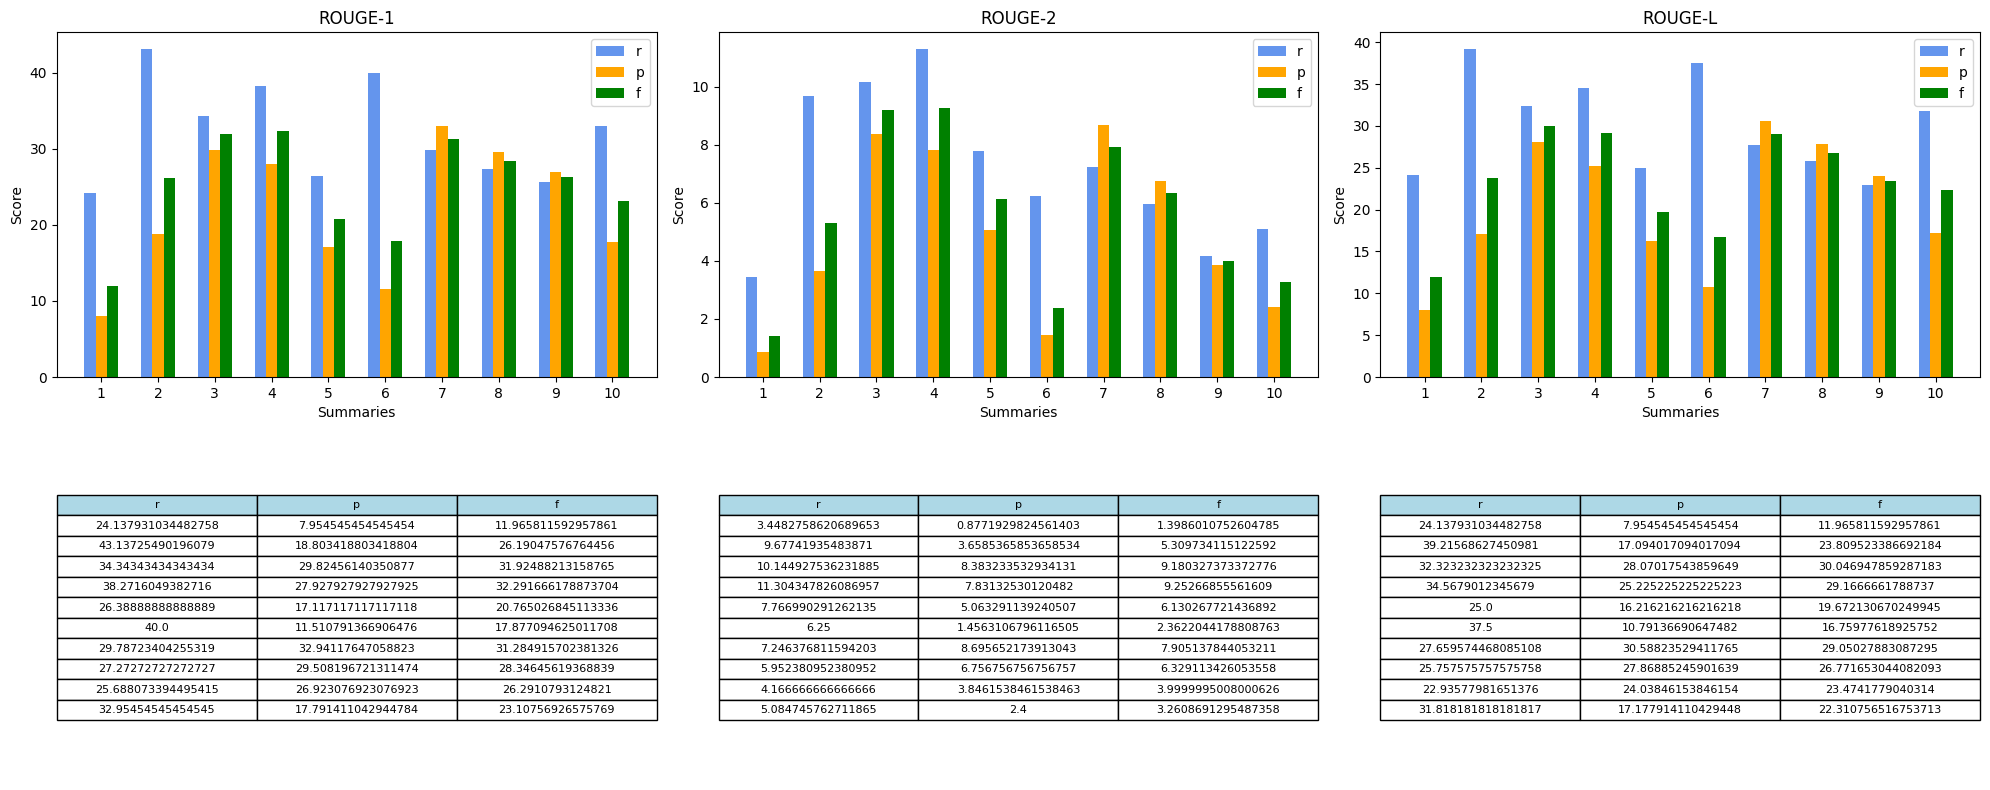

In [61]:

def rouge_barplot(df1, df2, df3, title1, title2, title3):
    fig, axes = plt.subplots(2, 3, figsize=(20, 8))

    for ax, df, title in zip(axes[0], [df1, df2, df3], [title1, title2, title3]):
        x = np.arange(len(df))  
        width = 0.20
        multiplier = 0  

        for attribute, color, label in zip(['r', 'p', 'f'], ['cornflowerblue', 'orange', 'green'], ['r', 'p', 'f']):
            measurement = df[attribute]
            offset = width * multiplier
            ax.bar(x + offset, measurement, width, label=label, color=color)
            multiplier += 1  

        ax.set_title(title)
        ax.set_xlabel('Summaries')
        ax.set_ylabel('Score')
        ax.set_xticks(x + width)  
        ax.set_xticklabels([f"{i+1}" for i in x])  
        ax.legend()

    for ax, df in zip(axes[1], [df1, df2, df3]):
        ax.axis('tight')
        ax.axis('off')
        ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["lightblue"]*df.shape[1])

    plt.tight_layout()
    plt.show()

rouge_barplot(rouge1_df, rouge2_df, rougel_df, 'ROUGE-1', 'ROUGE-2', 'ROUGE-L')


### **Visualize ROUGE Scores with Box Plots**

This section generates box plots to visualize the distribution of ROUGE scores (Recall, Precision, F1) for different types of ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L).  

- **Box Plots**: Each plot shows the distribution of three ROUGE metrics—recall (`r`), precision (`p`), and F1 score (`f`)—for each sample.  
  - The box represents the interquartile range (IQR), with the line inside the box indicating the median.  
  - Whiskers extend to show the range of the data, and outliers are displayed as individual points.  

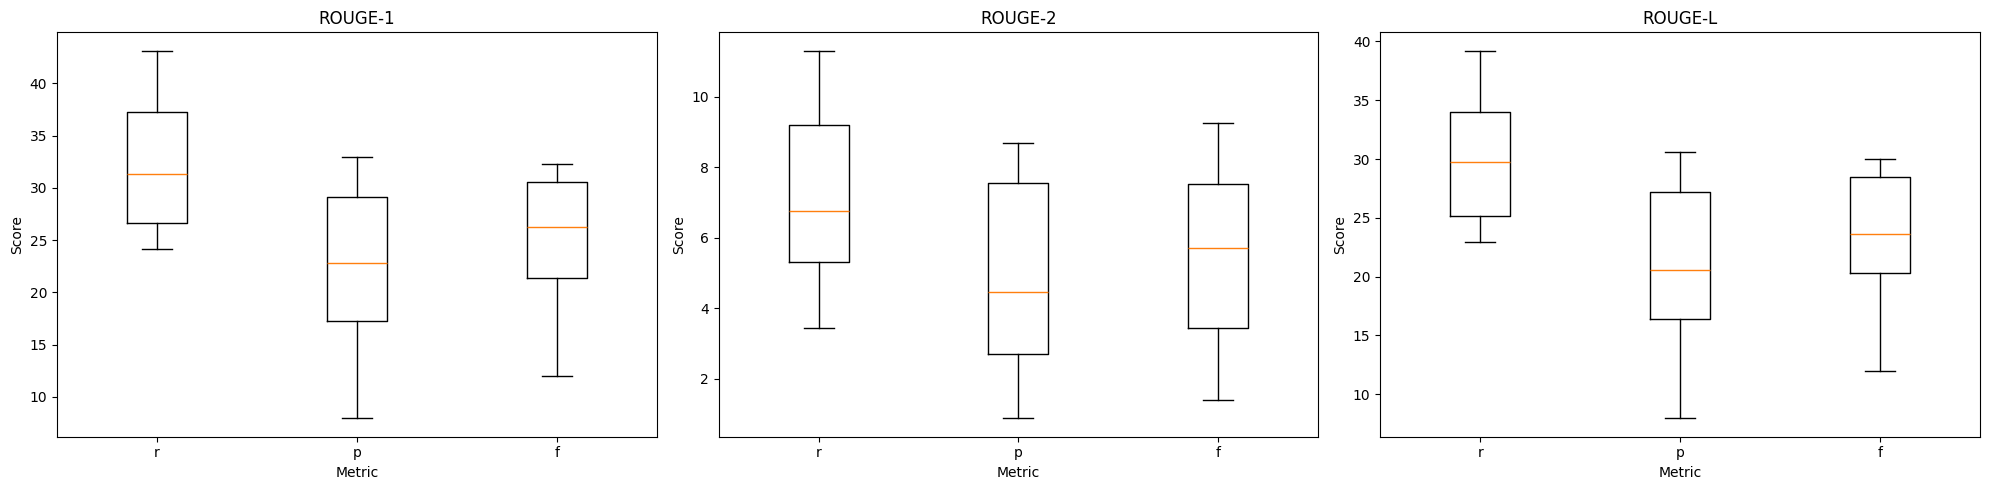

In [65]:
def rouge_boxplot(df1, df2, df3, title1, title2, title3):
    plt.figure(figsize=(20, 5))

    for i, (df, title) in enumerate(zip([df1, df2, df3], [title1, title2, title3]), start=1):
        plt.subplot(1, 3, i)
        plt.boxplot([df['r'], df['p'], df['f']], tick_labels=['r', 'p', 'f'])
        plt.title(title)
        plt.xlabel('Metric')
        plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

rouge_boxplot(rouge1_df, rouge2_df, rougel_df, 'ROUGE-1', 'ROUGE-2', 'ROUGE-L')


### **Final Evaluation of ROUGE Scores**

The following table summarizes the ROUGE scores (Recall, Precision, and F1) for three different metrics: ROUGE-1, ROUGE-2, and ROUGE-L. The values include count, mean, standard deviation, minimum, maximum, and percentiles.

#### **ROUGE-1**  
| Metric | Recall (r) | Precision (p) | F1 Score (f) |
|--------|------------|---------------|--------------|
| **Count** | 10 | 10 | 10 |
| **Mean**  | 32.20 | 22.03 | 25.00 |
| **Std Dev** | 6.61 | 8.54 | 6.64 |
| **Min**   | 24.14 | 7.95  | 11.97 |
| **25th Percentile** | 26.61 | 17.29 | 21.35 |
| **50th Percentile (Median)** | 31.37 | 22.86 | 26.24 |
| **75th Percentile** | 37.29 | 29.11 | 30.55 |
| **Max**   | 43.14 | 32.94 | 32.29 |

#### **ROUGE-2**  
| Metric | Recall (r) | Precision (p) | F1 Score (f) |
|--------|------------|---------------|--------------|
| **Count** | 10 | 10 | 10 |
| **Mean**  | 7.10  | 4.90  | 5.51  |
| **Std Dev** | 2.63  | 2.90  | 2.76  |
| **Min**   | 3.45  | 0.88  | 1.40  |
| **25th Percentile** | 5.30  | 2.71  | 3.45  |
| **50th Percentile (Median)** | 6.75  | 4.45  | 5.72  |
| **75th Percentile** | 9.20  | 7.56  | 7.51  |
| **Max**   | 11.30 | 8.70  | 9.25  |

#### **ROUGE-L**  
| Metric | Recall (r) | Precision (p) | F1 Score (f) |
|--------|------------|---------------|--------------|
| **Count** | 10 | 10 | 10 |
| **Mean**  | 30.09 | 20.50 | 23.30 |
| **Std Dev** | 5.81  | 7.75  | 5.88  |
| **Min**   | 22.94 | 7.95  | 11.97 |
| **25th Percentile** | 25.19 | 16.44 | 20.33 |
| **50th Percentile (Median)** | 29.74 | 20.61 | 23.64 |
| **75th Percentile** | 34.01 | 27.21 | 28.48 |
| **Max**   | 39.22 | 30.59 | 30.05 |

#### **Interpretation**
- **ROUGE-1**: Shows a higher mean recall and precision, with a fairly wide spread between the lowest and highest values, indicating variability in the recall and precision of the summaries.
- **ROUGE-2**: Exhibits lower recall and precision compared to ROUGE-1, but still shows reasonable variation. The F1 scores for ROUGE-2 are generally lower, suggesting room for improvement in handling bigram overlaps.
- **ROUGE-L**: This metric shows results similar to ROUGE-1, with slightly lower precision. The F1 scores also follow a similar trend, indicating that the model performs better with longer subsequences (ROUGE-L) than with bigram overlaps (ROUGE-2).

Overall, the ROUGE-1 and ROUGE-L scores are generally higher, while ROUGE-2 presents relatively lower performance, especially in terms of precision and recall. Further tuning or improvements to the model may be needed, particularly for handling bigram overlap more effectively.

### **Conclusion**

- **ROUGE-1**: The model shows moderate performance with a recall of 32.20 and precision of 22.03, but the low precision indicates a lot of irrelevant words in the summaries. The F1 score (25.00) suggests the model captures some relevant content but still generates noisy output.

- **ROUGE-2**: The model performs poorly here with a recall of 7.10 and precision of 4.90 (F1 = 5.51). It struggles with capturing bigram relationships, reflecting a lack of context and coherence in the generated summaries.

- **ROUGE-L**: The results are better than ROUGE-2 but still subpar. The recall of 30.09 and precision of 20.50 (F1 = 23.30) suggest some success in capturing longer sequences, but the overall performance is still limited.

### **Key Issues**
- **Noisy Summaries**: The model generates irrelevant content (low precision).
- **Weak Context Understanding**: Poor performance on bigrams (ROUGE-2) indicates difficulty in capturing multi-word relationships.
- **Limited Sequence Handling**: Struggles with maintaining structure over longer sequences (ROUGE-L).

### **Improvements**
- **Better Data**: More diverse or domain-specific data could help improve context and structure understanding.
- **Model Tuning**: Further fine-tuning, particularly for bigrams and sequence coherence, could improve performance.
- **Noise Filtering**: Implementing better filtering to reduce irrelevant words and improve precision.

Overall, the model needs significant improvements in capturing multi-word relationships and reducing noisy output for better summarization quality.

<br>

### **Evaluate Summaries with BERTScore**

To further assess the quality of the generated summaries, we calculate **BERTScore**, which evaluates the similarity between the generated summaries and the reference summaries based on the contextual meaning of words. The following steps are taken:

**BERTScore Calculation**: We use the `bert-score` library to compute **Precision**, **Recall**, and **F1** scores for the generated and reference summaries. These scores are based on the semantic similarity between the two sets of summaries.
   - **Precision**: Measures how well the words in the generated summary align semantically with the reference summary.
   - **Recall**: Measures how many words from the reference summary are captured by the generated summary.
   - **F1 Score**: Combines Precision and Recall into a single measure of overall semantic similarity.


In [3]:
from bert_score import score
import json

In [4]:
# initial summary
with open('../data/summary.json', 'r') as file:
    generated = json.load(file)

# initial reference
with open('../data/references.json', 'r') as file:
    reference = json.load(file)

In [5]:
generated_summaries = [entry["post_summary"] for entry in generated]    
reference_summaries = [entry["comments_summary"] for entry in reference]

In [7]:
P, R, F1 = score(generated_summaries, reference_summaries, lang="en", verbose=True)

print("Precision: ", P)
print("Recall: ", R)
print("F1: ", F1)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.61 seconds, 6.23 sentences/sec
Precision:  tensor([0.8500, 0.8782, 0.8721, 0.8817, 0.8632, 0.8753, 0.8720, 0.8810, 0.8617,
        0.8689])
Recall:  tensor([0.8084, 0.8430, 0.8714, 0.8671, 0.8489, 0.8230, 0.8766, 0.8804, 0.8684,
        0.8304])
F1:  tensor([0.8286, 0.8603, 0.8717, 0.8743, 0.8560, 0.8484, 0.8743, 0.8807, 0.8650,
        0.8492])


### **Convert BERTScore Results into a DataFrame**

To organize the **BERTScore** results, we convert the Precision (P), Recall (R), and F1 scores into a **Pandas DataFrame** for easier analysis and visualization. The DataFrame provides a tabular format, where each row corresponds to a generated summary and the respective BERTScore metrics.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
bert_df = pd.DataFrame({"P": P.tolist(), "R": R.tolist(), "F1": F1.tolist()})

bert_df

,P,R,F1
0,0.849953,0.808364,0.828637
1,0.878238,0.843025,0.860271
2,0.872100,0.871391,0.871745
3,0.881697,0.867073,0.874324
4,0.863244,0.848860,0.855991
5,0.875335,0.822992,0.848357
6,0.872045,0.876636,0.874335
7,0.881004,0.880404,0.880704
8,0.861679,0.868364,0.865009
9,0.868940,0.830367,0.849216


### **Average BERTScore Metrics**

After calculating the individual Precision, Recall, and F1 scores for each generated summary, we compute the **average** of these metrics to get an overall view of the model's performance.

- **Average Precision**: The mean of Precision scores across all samples, indicating the overall semantic relevance of the generated summaries.
- **Average Recall**: The mean of Recall scores, showing how well the generated summaries capture the key information from the reference summaries.
- **Average F1 Score**: The harmonic mean of Precision and Recall, providing a balanced measure of the model's overall semantic performance.


In [18]:
avg_precision = P.mean().item()
avg_recall = R.mean().item()
avg_f1 = F1.mean().item()

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Average Precision: 0.870423436164856
Average Recall: 0.8517476320266724
Average F1 Score: 0.8608589172363281


### **Summary Statistics for BERTScore**

To better understand the distribution of the **BERTScore** metrics, we compute the summary statistics for Precision, Recall, and F1 scores.

In [67]:
summary_bert = bert_df.describe()
summary_bert

,P,R,F1
count,10.000000,10.000000,10.000000
mean,0.870423,0.851748,0.860859
std,0.009882,0.024918,0.015799
min,0.849953,0.808364,0.828637
25%,0.864668,0.833531,0.850910
50%,0.872072,0.857966,0.862640
75%,0.877512,0.870634,0.873679
max,0.881697,0.880404,0.880704


### **BERTScore Bar Plot**

To visualize the **BERTScore** metrics (Precision, Recall, F1) for each generated summary, we create a **bar plot**. This plot provides a clear comparison of how each summary performs across these metrics.

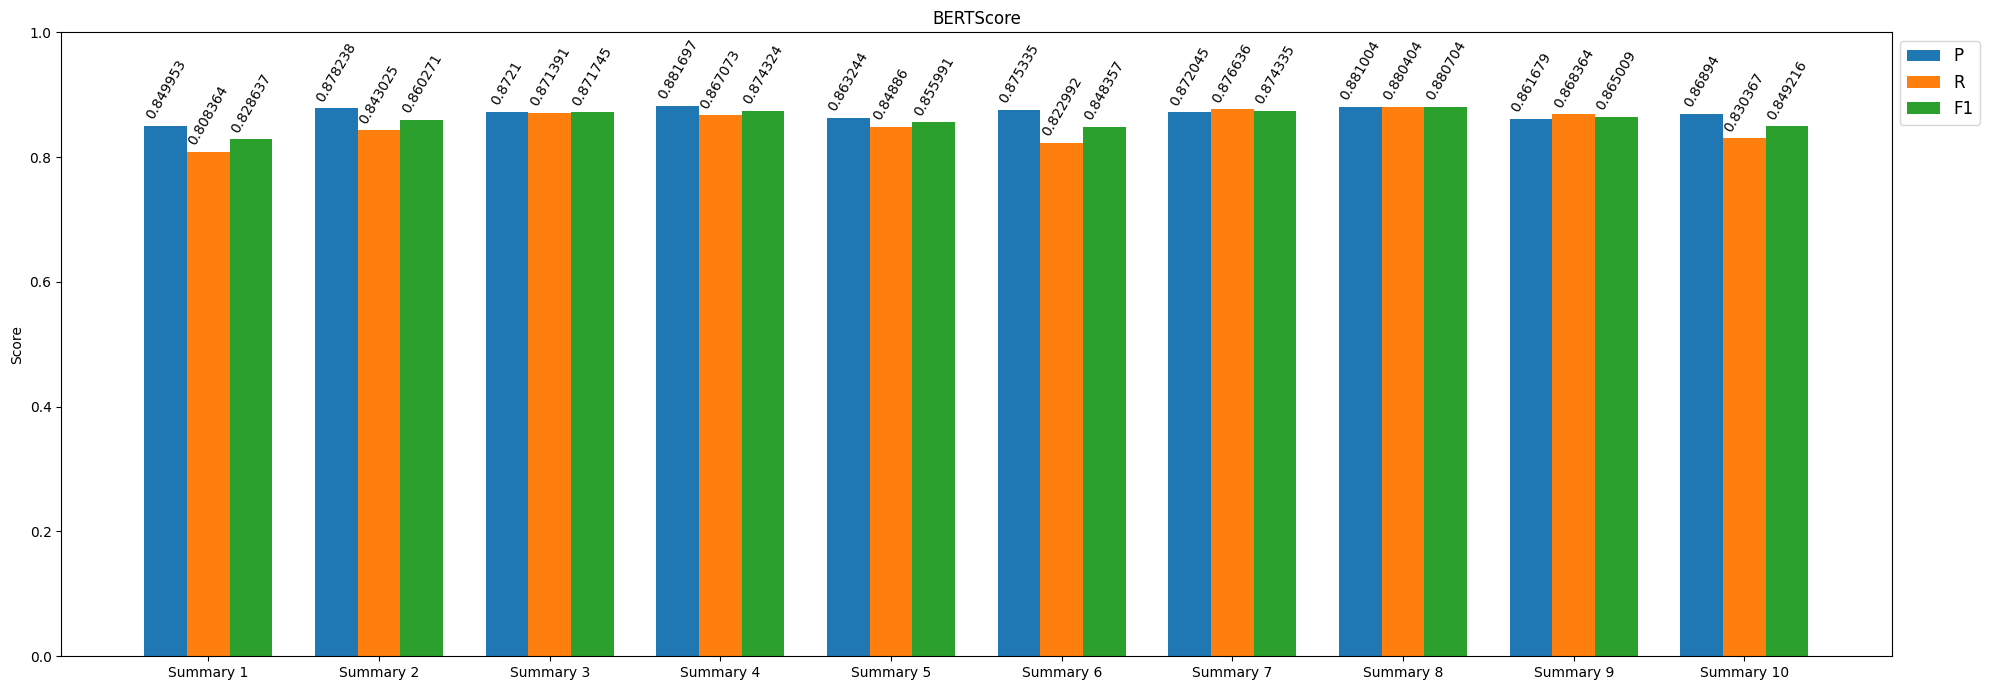

In [21]:
def bert_bar(df, title):
    fig, ax = plt.subplots(figsize=(20, 7))

    x = np.arange(len(df))  
    width = 0.25
    multiplier = 0 

    for attribute in ['P', 'R', 'F1']:
        measurement = df[attribute]
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)  
        ax.bar_label(rects, padding=3, rotation=60)
        multiplier += 1  

    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x+width)  
    ax.set_xticklabels([f"Summary {i+1}" for i in x])  
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set_ylim(0, 1)  

    plt.tight_layout()
    plt.show()

bert_bar(bert_df, 'BERTScore')


### **Final Evaluation of BERTScore**

The following table summarizes the BERTScore metrics **(Precision, Recall, and F1)** across different summaries.

#### **BERTScore**  
| Metric            | Value               |
|-------------------|---------------------|
| **Average Precision** | 0.8704            |
| **Average Recall**    | 0.8517            |
| **Average F1 Score**  | 0.8609            |

#### **Interpretation**
- **Precision**: Strong performance with an average of 87.04%. The model generates relevant tokens but can still improve by reducing irrelevant ones.
- **Recall**: Slightly lower at 85.17%, with more variability across summaries. The model misses some relevant content.
- **F1 Score**: Good balance at 86.09%, indicating solid overall performance.

### **Conclusion**
- **Precision**: High, but improvements are needed in reducing irrelevant tokens.
- **Recall**: Needs improvement to capture all relevant content, especially in complex summaries.
- **F1 Score**: Strong, but further fine-tuning could optimize recall and overall performance.

### **Improvements**
- **Focus on Recall**: Work on capturing more relevant content.
- **Error Analysis**: Investigate lower recall cases for insights.
- **Further Tuning**: Fine-tune the model for better performance.

#### **Notes:**
- **Model Initialization**: Some weights of `RobertaModel` were not initialized from the model checkpoint at `roberta-large` and are newly initialized: `['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']`.
- **Training Suggestion**: It's recommended to train this model on a downstream task for better performance in prediction and inference.